In [1]:
import pandas as pd
import numpy as np
import string
import keras
import tensorflow
import nltk
nltk.download('all')
import threading # will potentially use multi-threading
from nltk.stem.porter import *
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize

Using TensorFlow backend.
[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to
[nltk_data]    |     /Users/haritha/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     /Users/haritha/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /Users/haritha/nltk_data...
[nltk_data]    |   Package biocreative_ppi is already up-to-date!
[nltk_data]    | Downloading package brown to
[nltk_data]    |     /Users/haritha/nltk_data...
[nltk_data]    |   Package brown is already up-to-date!
[nltk_data]    | Downloading package brown_tei to
[nltk_data]    |     /Users/haritha/nltk_data...
[nltk_data]    |   Package brown_tei is already up-to-date!
[nltk_data]    | Downloading package cess_cat to
[nltk_data]    |     /Users/haritha/nltk_data...
[nltk_data]    |   Package cess_cat 

[nltk_data]    |   Package twitter_samples is already up-to-date!
[nltk_data]    | Downloading package udhr to
[nltk_data]    |     /Users/haritha/nltk_data...
[nltk_data]    |   Package udhr is already up-to-date!
[nltk_data]    | Downloading package udhr2 to
[nltk_data]    |     /Users/haritha/nltk_data...
[nltk_data]    |   Package udhr2 is already up-to-date!
[nltk_data]    | Downloading package unicode_samples to
[nltk_data]    |     /Users/haritha/nltk_data...
[nltk_data]    |   Package unicode_samples is already up-to-date!
[nltk_data]    | Downloading package universal_treebanks_v20 to
[nltk_data]    |     /Users/haritha/nltk_data...
[nltk_data]    |   Package universal_treebanks_v20 is already up-to-
[nltk_data]    |       date!
[nltk_data]    | Downloading package verbnet to
[nltk_data]    |     /Users/haritha/nltk_data...
[nltk_data]    |   Package verbnet is already up-to-date!
[nltk_data]    | Downloading package verbnet3 to
[nltk_data]    |     /Users/haritha/nltk_data...

In [38]:
from nltk.corpus import words
import os
from sklearn.manifold import TSNE
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [90]:
df_review = pd.read_csv("df_review.csv")
df_review = df_review[['id','reviews.text', 'reviews.rating']]
df_review = df_review.dropna(subset = [ 'reviews.rating'])
df_review.reset_index(drop=True, inplace=True)
df_review.head(10)

,id,reviews.text,reviews.rating
0,AVpe7AsMilAPnD_xQ78G,I initially had trouble deciding between the p...,5.0
1,AVpe7AsMilAPnD_xQ78G,Allow me to preface this with a little history...,5.0
2,AVpe7AsMilAPnD_xQ78G,I am enjoying it so far. Great for reading. Ha...,4.0
3,AVpe7AsMilAPnD_xQ78G,I bought one of the first Paperwhites and have...,5.0
4,AVpe7AsMilAPnD_xQ78G,I have to say upfront - I don't like coroporat...,5.0
5,AVpe7AsMilAPnD_xQ78G,"Had older model, that you could text to speech...",4.0
6,AVpe7AsMilAPnD_xQ78G,This is a review of the Kindle Paperwhite laun...,5.0
7,AVpe7AsMilAPnD_xQ78G,I love my kindle! I got one for my fiance on h...,5.0
8,AVpe7AsMilAPnD_xQ78G,"Vraiment bon petit appareil , lger et facile d...",4.0
9,AVpe7AsMilAPnD_xQ78G,Exactly what it is supposed to be. Works great...,5.0


In [53]:
# Clean String
def cleanString(review,stopWords):
    """
    Cleans input string using set rules.
    Cleaning rules:         Every word is lemmatized and lowercased. Stopwords and non alpha-numeric words are removed.
                            Each sentence ends with a period.
    Input:   review       - string(in sentence structure)
             stopWords    - set of strings which should be removed from review
    Output:  returnString - cleaned input string
             idx_list     - list of lists, one list is equal to one sentence. In every list are the index
                            of each word as they appeared in the non cleaned sentence
                            e.g. nonCleaned = "This is a test." -> cleaned = "This test." -> cleaned_index = [[0,3]]
    """
    # Init the Wordnet Lemmatizer
    lemmatizer = WordNetLemmatizer()
    returnString = ""
    sentence_token = sent_tokenize(review)
    idx_list = []
    for j in range(len(sentence_token)):
        single_sentence = word_tokenize(sentence_token[j])
        sentences_filtered = [(idx,lemmatizer.lemmatize(w.lower())) for idx,w in enumerate(single_sentence)
                              if w.lower() not in stopwords.words('english') and w.isalnum()]
        idx_list.append([x[0] for x in sentences_filtered])
        word_list = [x[1] for x in sentences_filtered]
        returnString = returnString + ' '.join(word_list) + ' . '
    
    return returnString, idx_list, single_sentence


In [91]:
# Parameters
MAX_SENTENCE_NUM = 9
MAX_WORD_NUM = 40
MAX_FEATURES = 200000 

# Tokenization
# Word index

n = df_review.shape[0]

"""
Using the keras Tokenizer class a word index is built.
The most 'MAX_FEATURES' used words are tokenized to a number.
this dictionary is saved in word_index
"""
texts = []
for i in range(n):
    s = df_review['reviews.text'].iloc[i]
    s = ' '.join([word.strip(string.punctuation) for word in s.split() if word.strip(string.punctuation) is not ""])
    texts.append(s)
tokenizer = keras.preprocessing.text.Tokenizer(num_words=MAX_FEATURES,lower=True, oov_token=None)
tokenizer.fit_on_texts(texts)
word_index = tokenizer.word_index

print('Number of tokens: ' + str(len(word_index)))

Number of tokens: 5757


In [92]:
df_review['reviews.text'][890]

'Great sound and portablebility. Nice style, lithium battery, requires wifi and there are internet radio stations and news. Amazon has features available as well. I use mine a lot.'

In [93]:

cleanString(df_review['reviews.text'][890], stopwords)

('great sound portablebility . nice style lithium battery requires wifi internet radio station news . amazon feature available well . use mine lot . ',
 [[0, 1, 3], [0, 1, 3, 4, 6, 7, 11, 12, 13, 15], [0, 2, 3, 5], [1, 2, 4]],
 ['I', 'use', 'mine', 'a', 'lot', '.'])

In [94]:
# Load word vectors from pre-trained dataset
embeddings_index = {}
f = open(os.path.join(os.getcwd(), 'glove.6B.100d.txt'), encoding='utf8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))



Found 400000 word vectors.


In [95]:
# Embedding

EMBED_SIZE = 100

min_wordCount = 2
absent_words = 0
small_words = 0
embedding_matrix = np.zeros((len(word_index) + 1, EMBED_SIZE))
word_counts = tokenizer.word_counts
for word, i in word_index.items():
    if word_counts[word] > min_wordCount:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector
        else:
            absent_words += 1
    else:
        small_words += 1
print('Total absent words are', absent_words, 'which is', "%0.2f" % (absent_words * 100 / len(word_index)),
      '% of total words')
print('Words with '+str(min_wordCount)+' or less mentions', small_words, 'which is', "%0.2f" % (small_words * 100 / len(word_index)),
      '% of total words')
print(str(len(word_index)-small_words-absent_words) + ' words to proceed.')

Total absent words are 138 which is 2.40 % of total words
Words with 2 or less mentions 2792 which is 48.50 % of total words
2827 words to proceed.


In [96]:
embedding_matrix[word_index['wish']]

array([-0.18573999,  0.33739999,  0.22002   , -0.17411999, -0.20810001,
        0.065849  , -0.67724001, -0.021098  ,  0.34239   , -0.28331   ,
       -0.24129   ,  0.32093999,  0.63810003, -0.20578   , -0.49623001,
       -0.38701001,  0.26163   ,  0.57085001, -1.04390001,  0.84697998,
       -0.32833001,  0.093014  , -0.66772002, -0.34823   , -0.20953   ,
        0.41198   ,  0.1163    , -0.25376999,  1.03299999, -0.50541002,
       -0.13981   ,  0.85241002,  0.45214999,  0.18548   ,  0.18926001,
        0.65697998,  0.32034001,  0.065963  ,  0.10379   , -0.66953999,
       -0.34965   ,  0.40617999,  0.61378002, -0.69779003, -0.41830999,
       -0.17193   ,  0.057787  , -0.11909   , -0.033902  , -1.04929996,
        0.25382999,  0.19976   ,  0.13756999,  0.38247001,  0.34845999,
       -1.38569999,  0.22776   , -0.041017  ,  0.95434999, -0.085851  ,
       -0.23647   ,  0.72874999, -0.76482999, -0.34062999,  0.61935002,
        0.26714   , -0.05441   ,  0.62133998, -0.46303999, -0.82

In [97]:
def split_df(dataframe, column_name, training_split, validation_split, test_split):
    """
    Splits a pandas dataframe into trainingset, validationset and testset in specified ratio.
    All sets are balanced, which means they have the same ratio for each category as the full set.
    Input:   dataframe        - Pandas Dataframe, should include a column for data and one for categories
             column_name      - Name of dataframe column which contains the categorical output values
             training_split   - from ]0,1[, default = 0.6
             validation_split - from ]0,1[, default = 0.2        
             test_split       - from ]0,1[, default = 0.2
                                Sum of all splits need to be 1
    Output:  train            - Pandas DataFrame of trainset
             validation       - Pandas DataFrame of validationset
             test             - Pandas DataFrame of testset
    """
    if training_split + validation_split + test_split != 1.0:
        raise ValueError('Split paramter sum should be 1.0')
        
    total = len(dataframe.index)
 
    train = dataframe.reset_index().groupby(column_name).apply(lambda x: x.sample(frac=training_split))\
    .reset_index(drop=True).set_index('index')
    train = train.sample(frac=1)
    temp_df = dataframe.drop(train.index)
    validation = temp_df.reset_index().groupby(column_name)\
    .apply(lambda x: x.sample(frac=validation_split/(test_split+validation_split)))\
           .reset_index(drop=True).set_index('index')
    validation = validation.sample(frac=1)
    test = temp_df.drop(validation.index)
    test = test.sample(frac=1)
    
    print('Total: ', len(dataframe))
    print('Training: ', len(train), ', Percentage: ', len(train)/len(dataframe))
    print('Validation: ', len(validation), ', Percentage: ', len(validation)/len(dataframe))
    print('Test:', len(test), ', Percentage: ', len(test)/len(dataframe))

    return train, validation, test

train, validation, test = split_df(df_review[['reviews.rating', 'reviews.text']], 'reviews.text',0.75,0.15,0.1)


Total:  1177
Training:  1103 , Percentage:  0.9371282922684792
Validation:  50 , Percentage:  0.04248088360237893
Test: 24 , Percentage:  0.020390824129141887


In [24]:
import tensorflow as tf
import os
from tensorflow.python.keras.layers import Layer
from tensorflow.python.keras import backend as K

class AttentionLayer(Layer):
    """
    Hierarchial Attention Layer as described by Hierarchical Attention Networks for Document Classification(2016)
    - Yang et. al.
    Source: https://www.cs.cmu.edu/~hovy/papers/16HLT-hierarchical-attention-networks.pdf
    Theano backend
    """
    def __init__(self,attention_dim=100,return_coefficients=False,**kwargs):
        # Initializer 
        self.supports_masking = True
        self.return_coefficients = return_coefficients
        self.init = initializers.get('glorot_uniform') # initializes values with uniform distribution
        self.attention_dim = attention_dim
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        # Builds all weights
        # W = Weight matrix, b = bias vector, u = context vector
        assert len(input_shape) == 3
        # casting "Dimension" type of input_shape's elements to "int" type
        #input_shape = tuple([i if (isinstance(i, float) or i is None else i.value for i in input_shape)]) 
        self.W = K.variable(self.init((input_shape[-1].value, self.attention_dim)),name='W')
        self.b = K.variable(self.init((self.attention_dim, )),name='b')
        self.u = K.variable(self.init((self.attention_dim, 1)),name='u')
        self._trainable_weights = [self.W, self.b, self.u]

        super(AttentionLayer, self).build(input_shape)

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, hit, mask=None):
        # Here, the actual calculation is done
        uit = K.bias_add(K.dot(hit, self.W),self.b)
        uit = K.tanh(uit)
        
        ait = K.dot(uit, self.u)
        ait = K.squeeze(ait, -1)
        ait = K.exp(ait)
        
        if mask is not None:
            ait *= K.cast(mask, K.floatx())

        ait /= K.cast(K.sum(ait, axis=1, keepdims=True) + K.epsilon(), K.floatx())
        ait = K.expand_dims(ait)
        weighted_input = hit * ait
        
        if self.return_coefficients:
            return [K.sum(weighted_input, axis=1), ait]
        else:
            return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        if self.return_coefficients:
            return [(input_shape[0], input_shape[-1]), (input_shape[0], input_shape[-1], 1)]
        else:
            return input_shape[0], input_shape[-1]

In [137]:
"""
Create Keras functional model for hierarchical attention network
"""
import tensorflow.keras
from tensorflow.python.keras.layers import Embedding
from tensorflow.python.keras.layers import Input
from tensorflow.python.keras.layers import Bidirectional, GRU, Dense
from tensorflow.python.keras.models import Model
from tensorflow.python.keras import initializers
from tensorflow.python.keras.layers import TimeDistributed
from tensorflow.python.keras.layers import Dropout
embedding_layer = Embedding(len(word_index) + 1,EMBED_SIZE,weights=[embedding_matrix], 
                            input_length=MAX_WORD_NUM, trainable=False,name='word_embedding')

# Words level attention model
word_input = Input(shape=(MAX_WORD_NUM,), dtype='int32',name='word_input')
word_sequences = embedding_layer(word_input)
word_gru = Bidirectional(GRU(50, return_sequences=True),name='word_gru')(word_sequences)
word_dense = Dense(100, activation='relu', name='word_dense')(word_gru) 
word_att,word_coeffs = AttentionLayer(EMBED_SIZE,True,name='word_attention')(word_dense)
wordEncoder = Model(inputs = word_input,outputs = word_att)


# Sentence level attention model
sent_input = Input(shape=(MAX_SENTENCE_NUM,MAX_WORD_NUM), dtype='int32',name='sent_input')
print("sent_input ",sent_input)
sent_encoder = TimeDistributed(wordEncoder,name='sent_linking')(sent_input)
sent_gru = Bidirectional(GRU(50, return_sequences=True),name='sent_gru')(sent_encoder)
sent_dense  = Dense(100, activation='relu', name='sent_dense')(sent_gru) 
sent_att,sent_coeffs = AttentionLayer(EMBED_SIZE,return_coefficients=True,name='sent_attention')(sent_dense)
sent_drop = Dropout(0.5,name='sent_dropout')(sent_att)
preds = Dense(5, activation='softmax',name='output')(sent_drop)

# Model compile
model = Model(sent_input, preds)
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['acc'])
print(wordEncoder)
print("-------------------")
print(model.summary())

sent_input  Tensor("sent_input_10:0", shape=(?, 9, 40), dtype=int32)
-------------------
Model: "model_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sent_input (InputLayer)      [(None, 9, 40)]           0         
_________________________________________________________________
sent_linking (TimeDistribute (None, 9, 100)            641400    
_________________________________________________________________
sent_gru (Bidirectional)     (None, 9, 100)            45300     
_________________________________________________________________
sent_dense (Dense)           (None, 9, 100)            10100     
_________________________________________________________________
sent_attention (AttentionLay [(None, 100), (None, 9, 1 10200     
_________________________________________________________________
sent_dropout (Dropout)       (None, 100)               0         
___________________________________

In [98]:
import re
def clean_str(string):
    """
    Tokenization/string cleaning for dataset
    Every dataset is lower cased except
    """
    string = re.sub(r"\\", "", string)    
    string = re.sub(r"\'", "", string)    
    string = re.sub(r"\"", "", string)    
    return string.strip().lower()
paras = []
labels = []
texts = []

In [99]:
from keras.preprocessing.text import Tokenizer,  text_to_word_sequence
from nltk import tokenize
sent_lens = []
sent_nums = []
for idx in range(df_review['reviews.text'].shape[0]):
    text = clean_str(df_review['reviews.text'][idx])
    texts.append(text)
    sentences = tokenize.sent_tokenize(text)
    sent_nums.append(len(sentences))
    for sent in sentences:
        sent_lens.append(len(text_to_word_sequence(sent)))
    paras.append(sentences)



In [87]:
len(df_review['reviews.text'])

1177

In [101]:
tokenizer = Tokenizer(num_words=MAX_FEATURES, oov_token=True)
tokenizer.fit_on_texts(texts)

In [114]:
data = np.zeros((len(texts), MAX_SENTENCE_NUM, MAX_WORD_NUM), dtype='int32')
for i, sentences in enumerate(paras):
    for j, sent in enumerate(sentences):
        if j< MAX_SENTENCE_NUM:
            wordTokens = text_to_word_sequence(sent)
            k=0
            for _, word in enumerate(wordTokens):
                try:
                    if k<MAX_WORD_NUM and tokenizer.word_index[word]<MAX_FEATURES:
                        data[i,j,k] = tokenizer.word_index[word]
                        k=k+1
                except:
                    print(word)
                    pass

In [115]:
data

array([[[   4, 1380,   74, ...,  945,  252,  253],
        [   2,  290,   65, ...,    0,    0,    0],
        [  15,  173,  102, ...,   10,    2, 3739],
        ...,
        [   0,    0,    0, ...,    0,    0,    0],
        [   0,    0,    0, ...,    0,    0,    0],
        [   0,    0,    0, ...,    0,    0,    0]],

       [[ 387,   47,    3, ...,    0,    0,    0],
        [   4,   90,   33, ...,    0,    0,    0],
        [2550,    3,  132, ...,    0,    0,    0],
        ...,
        [   2,  993,    9, ...,    0,    0,    0],
        [  12,   22,   21, ...,    0,    0,    0],
        [ 336,    8,    2, ...,    0,    0,    0]],

       [[   4,   90, 1232, ...,    0,    0,    0],
        [  38,   10,  155, ...,    0,    0,    0],
        [  74,    2,  296, ...,    0,    0,    0],
        ...,
        [   0,    0,    0, ...,    0,    0,    0],
        [   0,    0,    0, ...,    0,    0,    0],
        [   0,    0,    0, ...,    0,    0,    0]],

       ...,

       [[ 145,  219,   2

In [117]:
ratings = pd.get_dummies(df_review['reviews.rating'])

In [119]:
print('Shape of data tensor:', data.shape)
print('Shape of ratings tensor:', ratings.shape)

Shape of data tensor: (1177, 9, 40)
Shape of ratings tensor: (1177, 5)


In [125]:
VALIDATION_SPLIT = 0.2
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
ratings = ratings.iloc[indices]
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

x_train = data[:-nb_validation_samples]
y_train = ratings[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = ratings[-nb_validation_samples:]


In [139]:
layer_name = 'sent_dropout'
intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer(layer_name).output)
intermediate_layer_model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['acc'])

# https://keras.io/getting-started/faq/#how-can-i-obtain-the-output-of-an-intermediate-layer
intermediate_output = intermediate_layer_model.predict(data)

In [140]:
intermediate_output.shape

(1177, 100)

In [141]:
#history = intermediate_layer_model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=7, batch_size=32)

In [129]:
x_train.shape

(942, 9, 40)

In [130]:
y_train.shape

(942, 5)

In [142]:
intermediate_output.shape

(1177, 100)

In [143]:
intermediate_output

array([[0.0000000e+00, 2.0882289e-03, 1.0989504e-04, ..., 2.7349382e-03,
        1.5228700e-03, 6.5845856e-03],
       [0.0000000e+00, 1.1700813e-02, 8.7393564e-05, ..., 3.3298314e-02,
        2.3038143e-02, 6.7113787e-02],
       [0.0000000e+00, 1.6262362e-03, 2.4272241e-04, ..., 5.0519081e-03,
        3.6278914e-03, 1.1471493e-02],
       ...,
       [0.0000000e+00, 9.2041520e-03, 0.0000000e+00, ..., 2.1255452e-02,
        1.4329316e-02, 5.0860129e-02],
       [0.0000000e+00, 2.9167105e-03, 0.0000000e+00, ..., 1.4915894e-02,
        1.1850116e-02, 3.5568330e-02],
       [0.0000000e+00, 3.2908034e-02, 5.5250712e-04, ..., 9.4544165e-02,
        5.8713213e-02, 2.0413473e-01]], dtype=float32)

In [173]:
import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

scaler = StandardScaler()
X_scaled = scaler.fit_transform(intermediate_output)
# cluster the data into five clusters
dbscan = DBSCAN(eps=0.7, min_samples = 8)
clusters = dbscan.fit_predict(X_scaled)
print(clusters)


[-1 -1 -1 -1 -1 -1 -1  0 -1 -1 -1 -1  0 -1 -1 -1  1 -1 -1 -1 -1 -1 -1  0
 -1 -1  2  0 -1 -1 -1 -1 -1 -1 -1  3 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1  4 -1 -1 -1  0 -1 -1 -1 -1 -1 -1  5 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  6  1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0  6  6 -1 -1 -1 -1
 -1 -1  3 -1 -1  0 -1  0 -1 -1 -1 -1 -1 -1 -1  5 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  3 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1  5 -1 -1 -1 -1 -1 -1 -1  0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1  6  6 -1  0 -1  0 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1  0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1  0 -1 -1  2 -1 -1 -1 -1 -1  7 -1 -1 -1  5  4 -1 -1  3 -1 -1 -1  1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  3 -1 -1 -1 -1  1 -1 -1 -1 -1  5 -1  4 -1
  0 -1 -1 -1  6 -1 -1 -1 -1 -1  4 -1 -1 -1 -1  7 -1

In [174]:
from scipy import stats
stats.describe(clusters)

DescribeResult(nobs=1177, minmax=(-1, 7), mean=-0.5548003398470688, variance=2.2710164779590682, skewness=3.650268612748817, kurtosis=12.469489949285268)

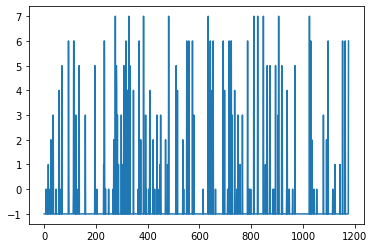

In [175]:
plt.plot(clusters)

In [167]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5, random_state=0).fit(intermediate_output)
kmeans.labels_

array([3, 0, 3, 3, 1, 3, 3, 1, 0, 1, 3, 4, 1, 3, 0, 0, 1, 4, 3, 0, 3, 1,
       2, 1, 3, 3, 1, 1, 1, 3, 3, 3, 3, 1, 3, 4, 1, 0, 3, 3, 3, 4, 0, 0,
       1, 4, 1, 3, 0, 3, 1, 4, 4, 1, 3, 1, 4, 4, 3, 3, 3, 1, 2, 3, 2, 3,
       3, 3, 1, 3, 2, 2, 3, 0, 3, 0, 1, 2, 0, 0, 1, 0, 1, 0, 3, 3, 3, 4,
       3, 0, 4, 0, 3, 3, 4, 1, 3, 3, 2, 3, 0, 0, 2, 3, 3, 4, 2, 3, 0, 3,
       3, 1, 4, 1, 4, 4, 0, 3, 4, 3, 3, 1, 4, 0, 3, 1, 3, 1, 3, 3, 3, 0,
       3, 4, 2, 1, 2, 1, 3, 3, 0, 0, 4, 2, 4, 0, 3, 3, 4, 2, 3, 0, 3, 3,
       0, 0, 3, 3, 2, 4, 3, 4, 0, 2, 4, 0, 3, 3, 1, 4, 2, 0, 0, 3, 4, 1,
       4, 3, 4, 2, 3, 3, 1, 0, 0, 1, 3, 2, 0, 3, 4, 3, 3, 0, 0, 2, 1, 0,
       3, 0, 2, 1, 1, 3, 1, 2, 0, 3, 0, 3, 3, 3, 3, 3, 0, 3, 4, 0, 0, 3,
       3, 1, 3, 0, 1, 2, 0, 3, 2, 3, 1, 0, 4, 4, 3, 1, 3, 1, 3, 4, 3, 0,
       4, 4, 3, 2, 1, 2, 0, 1, 3, 3, 3, 4, 4, 4, 3, 3, 3, 3, 3, 3, 1, 0,
       2, 0, 1, 3, 0, 1, 3, 3, 3, 3, 1, 4, 3, 0, 4, 1, 4, 3, 3, 4, 3, 3,
       2, 1, 3, 2, 3, 1, 3, 1, 0, 3, 1, 3, 4, 0, 0,

In [169]:
response = df_review['reviews.rating']

In [171]:
from sklearn.metrics.cluster import adjusted_rand_score
adjusted_rand_score(response, kmeans.labels_)

0.005495057086492998

Issues faced
1. float() argument must be a string or a number, not 'Dimension'-> self.W = K.variable(self.init((input_shape[-1]**.value**, self.attention_dim)),name='W')<br>
2. trainable weights read-only<br>
3. tuple cant be layer -> version error install tensorflow 1.14 and import all libs from tensorflow.python.keras

https://www.kaggle.com/hsankesara/news-classification-using-han/notebook

In [113]:
sentences

['i ordered this item to replace the one that no longer works.',
 'the directions for the new remove state to press the home button to go to the home screen (using the existing remote which does not work) you must use your existing remote for all the following steps.',
 'the existing remote does not work.',
 'this is why i bought a new one.',
 'i am sending all of this crap back to amazon and canceling this fire subscription.',
 'this has been a problem from day one and we have only had this for a few months.',
 'not worth the money.']